In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import scipy.signal as signal
from myFilter import Filter as Filter
import os
plt.style.use('seaborn-whitegrid')

def calFFT(signal, window = 2048 , shift = False , inDB = False, half = True, normf=True, fs=None):
    
    from scipy.fftpack import fft, fftshift
    mag = np.abs(fft(signal, window) / (len(signal)/2.0))
    freq = np.linspace(0, 1, len(mag))

    if shift:
        mag = np.abs(fftshift(mag / abs(mag).max() ) )
        freq = np.linspace(-0.5, 0.5, len(mag))
        
    
    if inDB:
        mag = 20 * np.log10( mag )

    if normf == False:
        if fs == None:
            raise ValueError("Give me 'fs'")
        freq = np.linspace(0, fs, len(mag) )

    if half:
        mag = mag[:len(mag)//2]
        freq = freq[:len(freq)//2]

    return mag, freq

def matInfo(mat):
    print(mat.keys())
    for key in mat.keys():
        print(f"mat['{key}'] - {mat[key]}")

samplingRate = 1000 #hz

In [2]:
def cal_correlation_coefficient(corr,mode='max',abs=False):
    import numpy as np
    _list_mode = ['max','sum']
    if(type(corr) != type(np.array([]))): corr = np.array(corr)
    if(mode not in _list_mode): raise ValueError(f"mode can only be {_list_mode}")
    if(abs): corr = np.abs(corr)
    # print(corr)
    if(mode == 'max'): return corr.max(axis=1)
    if(mode == 'sum'): return corr.sum(axis=1)

corr_mode = 'sum'
corr_abs = True
# cal_correlation_coefficient(R[:X_chs,X_chs:X_chs+Y_chs],mode='sum',abs=False)

In [3]:
# Load result from previous step
bss = scipy.io.loadmat('BSS/step2.mat')

pca = bss['pca']
pca_corr = bss['pca_corr'][0]

ilrma = bss['ilrma']
ilrma_corr = bss['ilrma_corr'][0]

cca = bss['cca']
cca_corr = bss['cca_corr'][0]

del(bss)

In [4]:
#  Load ECoG for Correlation Coefficients calculation
ECoG = scipy.io.loadmat('dataset/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat/ECoG_rest.mat')
ECoG = ECoG['ECoG']
# (128, 300000)

In [5]:
EVs = dict()

In [6]:
from sklearn.cross_decomposition import CCA
# Step4
# Sorting the Correlation Coefficient of each component
print(pca_corr)
# argsort is acsding. [::-1] will revert the result
group = []
pca_EVs = []


for idx in pca_corr.argsort()[::-1]:
    group.append(idx)
    print(pca[group].shape)
    # For each subset of EEG components, applied CCA
    ccA = CCA(n_components=len(group))
    ccA.fit(pca[group].T,ECoG.T)
    R = np.corrcoef(ccA.x_scores_.T,ccA.y_scores_.T)
    # the "sum of canonical correlation coefficients" was calculated for each freq, state, and subject

    ccc = cal_correlation_coefficient(R[:len(group),len(group):2*len(group)],mode='sum',abs=True)
    pca_EVs.append(ccc)
    if(len(group) == 16): break

EVs['pca'] = pca_EVs

[1.11620275 1.92321668 1.57905784 1.06816192 1.42210329 1.58783369
 1.31137826 1.27184437 1.52574255 0.91003249 1.21193236 1.09855706
 1.90151398 1.22922325 1.32471476 1.39643461]
(1, 300000)
(2, 300000)
(3, 300000)
(4, 300000)
(5, 300000)
(6, 300000)
(7, 300000)
(8, 300000)
(9, 300000)
(10, 300000)
(11, 300000)
(12, 300000)
(13, 300000)
(14, 300000)
(15, 300000)
(16, 300000)


In [7]:
pca_EVs = np.array(pca_EVs)
print(pca_EVs)
for i in pca_EVs:
    print(sum(i))

# print(pca_EVs)

[array([0.12571513]) array([0.15303828, 0.11211748])
 array([0.16295276, 0.1526426 , 0.10433187])
 array([0.16720068, 0.16202698, 0.11778736, 0.10359923])
 array([0.18594111, 0.16242892, 0.11979367, 0.11485386, 0.10112015])
 array([0.19839549, 0.18479958, 0.13289995, 0.11528838, 0.10861746,
       0.10108577])
 array([0.20000035, 0.18804084, 0.14583164, 0.12132571, 0.11238413,
       0.10252042, 0.09035481])
 array([0.20211504, 0.1905148 , 0.14605713, 0.13231808, 0.11240171,
       0.10664523, 0.09673303, 0.08816868])
 array([0.22333106, 0.20218058, 0.15430823, 0.14153532, 0.11775758,
       0.11029513, 0.10467407, 0.09618786, 0.0862364 ])
 array([0.23551744, 0.20270991, 0.15565231, 0.14345436, 0.13760855,
       0.11145587, 0.10977595, 0.10333148, 0.09576317, 0.08592341])
 array([0.23992487, 0.20341322, 0.16169741, 0.14346246, 0.13896278,
       0.12975946, 0.11145728, 0.1074368 , 0.10034513, 0.09392295,
       0.085935  ])
 array([0.24033455, 0.21085929, 0.16659327, 0.14373628, 0.139

In [8]:
print(ilrma_corr)
# argsort is acsding. [::-1] will revert the result
group = []
ilrma_EVs = []


for idx in ilrma_corr.argsort()[::-1]:
    group.append(idx)
    print(ilrma[group].shape)
    # For each subset of EEG components, applied CCA
    ccA = CCA(n_components=len(group))
    ccA.fit(ilrma[group].T,ECoG.T)
    R = np.corrcoef(ccA.x_scores_.T,ccA.y_scores_.T)
    # the "sum of canonical correlation coefficients" was calculated for each freq, state, and subject
    ccc = cal_correlation_coefficient(R[:len(group),len(group):2*len(group)],mode='sum',abs=True)
    ilrma_EVs.append(ccc)
    if(len(group) == 16): break

EVs['ilrma'] = ilrma_EVs

[0.89387775 0.9687917  0.87191529 1.09170352 1.24083348 1.0763857
 0.77957677 0.80384619 0.62742127 0.7794157  0.68363395 0.86344269
 1.17142753 1.02547387 0.74474732 1.04431318]
(1, 300000)
(2, 300000)
(3, 300000)
(4, 300000)
(5, 300000)
(6, 300000)
(7, 300000)
(8, 300000)
(9, 300000)
(10, 300000)
(11, 300000)
(12, 300000)
(13, 300000)
(14, 300000)
(15, 300000)
(16, 300000)


In [9]:
print(cca_corr)
# argsort is acsding. [::-1] will revert the result
group = []
cca_EVs = []


for idx in cca_corr.argsort()[::-1]:
    group.append(idx)
    print(cca[group].shape)
    # For each subset of EEG components, applied CCA
    ccA = CCA(n_components=len(group))
    ccA.fit(cca[group].T,ECoG.T)
    R = np.corrcoef(ccA.x_scores_.T,ccA.y_scores_.T)
    # the "sum of canonical correlation coefficients" was calculated for each freq, state, and subject
    ccc = cal_correlation_coefficient(R[:len(group),len(group):2*len(group)],mode='sum',abs=True)
    cca_EVs.append(ccc)
    if(len(group) == 16): break

EVs['cca'] = cca_EVs

[2.24640275 2.79993629 1.70613402 1.11679859 1.05274363 1.36338489
 1.19940576 1.18514694 1.27250003 1.33580075 0.88262981 0.99754068
 1.10933771 0.99603263 1.23702154 0.57014543]
(1, 300000)
(2, 300000)
(3, 300000)
(4, 300000)
(5, 300000)
(6, 300000)
(7, 300000)
(8, 300000)
(9, 300000)
(10, 300000)
(11, 300000)
(12, 300000)
(13, 300000)
(14, 300000)
(15, 300000)
(16, 300000)


In [10]:
if(os.path.exists('BSS') == False):
    os.mkdir('BSS')
    
scipy.io.savemat('BSS/EVs.mat',EVs)

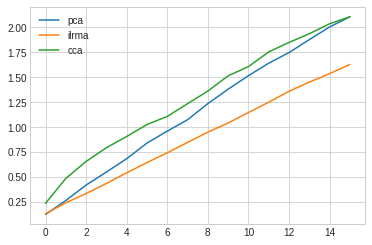

In [12]:
data = []
for i in pca_EVs:
    data.append(sum(i))

plt.plot(data, label='pca')

data = []
for i in ilrma_EVs:
    data.append(sum(i))

plt.plot(data, label='ilrma')

data = []
for i in cca_EVs:
    data.append(sum(i))

plt.plot(data, label='cca')

plt.legend()
# plt.axis('equal')